## Installing dependencies

In [28]:
!pip install autointent openai -q

In [29]:
import numpy as np
import pandas as pd

import importlib.resources as ires
import datasets

from autointent import Dataset

from autointent.modules.scoring import LinearScorer
from autointent.modules.decision import ArgmaxDecision

from autointent.metrics import decision_accuracy, decision_precision, \
    decision_recall, decision_f1, decision_roc_auc
from autointent.metrics import scoring_accuracy, scoring_precision, \
    scoring_recall, scoring_f1, scoring_roc_auc

from autointent.generation import Generator
from autointent.generation.utterances import UtteranceEvolver
from autointent.generation.chat_templates import GoofyEvolution, InformalEvolution
from autointent.generation.utterances import UtteranceGenerator
from autointent.generation.chat_templates import EnglishSynthesizerTemplate

In [30]:
import os

os.environ["OPENAI_API_KEY"] = "InnPracAutoIntent:Ilya_Tsybanov:c7843b1986c8444b83f44a5f21201fae"

In [67]:
datasets.logging.disable_progress_bar()

## Baseline

### Loading data

In [4]:
dataset = Dataset.from_hub("AutoIntent/snips")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.19k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/366k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/43.3k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/13084 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1400 [00:00<?, ? examples/s]

intents-00000-of-00001.parquet:   0%|          | 0.00/3.11k [00:00<?, ?B/s]

Generating intents split:   0%|          | 0/7 [00:00<?, ? examples/s]

In [5]:
dataset

{'train': Dataset({
     features: ['utterance', 'label'],
     num_rows: 13084
 }),
 'test': Dataset({
     features: ['utterance', 'label'],
     num_rows: 1400
 })}

In [6]:
dataset['train'][0]

{'utterance': 'Add Don and Sherri to my Meditate to Sounds of Nature playlist',
 'label': 0}

### Composing scorer

In [ ]:
scorer = LinearScorer(
    embedder_config="sergeyzh/rubert-tiny-turbo",
)

scorer.fit(dataset['train']['utterance'], dataset['train']['label'])

In [ ]:
scorer.predict(['hello, world!', 'goodbye!'])

array([[2.19398163e-04, 5.45256531e-04, 1.97540273e-01, 4.07960412e-02,
        8.95144936e-03, 7.50773394e-01, 1.17418748e-03],
       [3.67181611e-03, 3.84595742e-03, 1.48773777e-01, 1.79503111e-01,
        2.32520673e-03, 6.19926663e-01, 4.19534689e-02]])

### Evaluating

In [ ]:
test_preds_proba = scorer.predict(dataset['test']['utterance'])

In [ ]:
print("Baseline results")
print(f"Accuracy: {scoring_accuracy(dataset['test']['label'], test_preds_proba):.4f}")
print(f"Precision: {scoring_precision(dataset['test']['label'], test_preds_proba):.4f}")
print(f"Recall: {scoring_recall(dataset['test']['label'], test_preds_proba):.4f}")
print(f"F1: {scoring_f1(dataset['test']['label'], test_preds_proba):.4f}")

Baseline results
Accuracy: 0.9771
Precision: 0.9773
Recall: 0.9771
F1: 0.9772


## 10-shot

### Composing data

In [26]:
utterances = []
labels = []

for label in np.unique(dataset['train']['label']):
  label_col = dataset['train'].filter(lambda x: x['label'] == label)
  samples = np.random.choice(label_col, size=10)
  utterances.extend(list(sample['utterance'] for sample in samples))
  labels.extend(list(sample['label'] for sample in samples))

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13084 [00:00<?, ? examples/s]

In [ ]:
data_dict = {
    'train': [{
        'utterance': utterance,
        'label': label
    } for utterance, label in zip(utterances, labels)],

    'test': [{
        'utterance': utterance,
        'label': label
    } for utterance, label in zip(dataset['test']['utterance'], dataset['test']['label'])]б
}

In [ ]:
dataset10 = Dataset.from_dict(data_dict)
dataset10.intents = dataset.intents

In [ ]:
dataset10

{'train': Dataset({
     features: ['utterance', 'label'],
     num_rows: 70
 }),
 'test': Dataset({
     features: ['utterance', 'label'],
     num_rows: 1400
 })}

### Composing scorer

In [ ]:
scorer = LinearScorer(
    embedder_config="sergeyzh/rubert-tiny-turbo",
)

scorer.fit(dataset10['train']['utterance'], dataset10['train']['label'])

### Evaluating

In [ ]:
test_preds_proba = scorer.predict(dataset10['test']['utterance'])

In [ ]:
print("10-shot results")
print(f"Accuracy: {scoring_accuracy(dataset['test']['label'], test_preds_proba):.4f}")
print(f"Precision: {scoring_precision(dataset['test']['label'], test_preds_proba):.4f}")
print(f"Recall: {scoring_recall(dataset['test']['label'], test_preds_proba):.4f}")
print(f"F1: {scoring_f1(dataset['test']['label'], test_preds_proba):.4f}")

10-shot results
Accuracy: 0.8893
Precision: 0.8900
Recall: 0.8893
F1: 0.8876


## Augmentations (Evolver)

### Processing augmentations

In [ ]:
dataset10_evolver_aug = dataset10.copy()

In [ ]:
generator = Generator(
    base_url="http://193.187.173.33:8002/api/providers/openai/v1",
    model_name="gpt-3.5-turbo"
)

evolver = UtteranceEvolver(generator, prompt_makers=[GoofyEvolution(), InformalEvolution()])

In [ ]:
evolver.augment(dataset10_evolver_aug)

Dataset({
    features: ['label', 'utterance'],
    num_rows: 70
})

In [ ]:
dataset10_evolver_aug

{'train': Dataset({
     features: ['utterance', 'label'],
     num_rows: 140
 }),
 'test': Dataset({
     features: ['utterance', 'label'],
     num_rows: 1400
 })}

### Composing scorer

In [ ]:
scorer = LinearScorer(
    embedder_config="sergeyzh/rubert-tiny-turbo",
)

scorer.fit(
    dataset10_evolver_aug['train']['utterance'],
    dataset10_evolver_aug['train']['label']
)

### Evaluating

In [ ]:
test_preds_proba = scorer.predict(dataset['test']['utterance'])

In [ ]:
print("Augmentation (evolver) results")
print(f"Accuracy: {scoring_accuracy(dataset['test']['label'], test_preds_proba):.4f}")
print(f"Precision: {scoring_precision(dataset['test']['label'], test_preds_proba):.4f}")
print(f"Recall: {scoring_recall(dataset['test']['label'], test_preds_proba):.4f}")
print(f"F1: {scoring_f1(dataset['test']['label'], test_preds_proba):.4f}")

Augmentation (evolver) results
Accuracy: 0.8814
Precision: 0.8835
Recall: 0.8814
F1: 0.8811


## Augmentations (Generator)

### Processing augmentations

In [ ]:
dataset10_generator_aug = dataset10.copy()

In [ ]:
generator = Generator(
    base_url="http://193.187.173.33:8002/api/providers/openai/v1",
    model_name="gpt-3.5-turbo"
)

prompt = EnglishSynthesizerTemplate(dataset10_generator_aug)
augmenter = UtteranceGenerator(generator, prompt_maker=prompt)

In [ ]:
augmenter.augment(dataset10_generator_aug)

Filter:   0%|          | 0/70 [00:00<?, ? examples/s]

Filter:   0%|          | 0/70 [00:00<?, ? examples/s]

Filter:   0%|          | 0/70 [00:00<?, ? examples/s]

Filter:   0%|          | 0/70 [00:00<?, ? examples/s]

Filter:   0%|          | 0/70 [00:00<?, ? examples/s]

Filter:   0%|          | 0/70 [00:00<?, ? examples/s]

Filter:   0%|          | 0/70 [00:00<?, ? examples/s]

Filter:   0%|          | 0/70 [00:00<?, ? examples/s]

Filter:   0%|          | 0/70 [00:00<?, ? examples/s]

Filter:   0%|          | 0/70 [00:00<?, ? examples/s]

Filter:   0%|          | 0/70 [00:00<?, ? examples/s]

Filter:   0%|          | 0/70 [00:00<?, ? examples/s]

Filter:   0%|          | 0/70 [00:00<?, ? examples/s]

Filter:   0%|          | 0/70 [00:00<?, ? examples/s]

[Sample(utterance='Add "Smooth Operator" to my Chill Vibes playlist.', label=0),
 Sample(utterance='Put "Bohemian Rhapsody" on my Classic Rock Hits playlist.', label=0),
 Sample(utterance='Add "Shape of You" to my Top 40 Favorites playlist.', label=0),
 Sample(utterance='Please add "Hotel California" to my All-Time Best playlist.', label=0),
 Sample(utterance='Add "Blinding Lights" to my Workout Mix playlist.', label=0),
 Sample(utterance='Include "Watermelon Sugar" in my Summer Vibes playlist.', label=0),
 Sample(utterance='Add "Uptown Funk" to my Party Anthems playlist.', label=0),
 Sample(utterance='Put "Girls Like You" on my Feel-Good Jams playlist.', label=0),
 Sample(utterance='Add "Dance Monkey" to my Upbeat Pop Hits playlist.', label=0),
 Sample(utterance='Include "Can\'t Stop the Feeling', label=0),
 Sample(utterance='name: making restaurant reservations', label=1),
 Sample(utterance='', label=1),
 Sample(utterance='Make a reservation for five at a French bistro in downtown Lo

In [ ]:
dataset10_generator_aug

{'train': Dataset({
     features: ['utterance', 'label'],
     num_rows: 118
 }),
 'test': Dataset({
     features: ['utterance', 'label'],
     num_rows: 1400
 })}

### Composing scorer

In [ ]:
scorer = LinearScorer(
    embedder_config="sergeyzh/rubert-tiny-turbo",
)

scorer.fit(
    dataset10_evolver_aug['train']['utterance'],
    dataset10_evolver_aug['train']['label']
)

### Evaluating

In [ ]:
test_preds_proba = scorer.predict(dataset['test']['utterance'])

In [ ]:
print("Augmentation (generator) results")
print(f"Accuracy: {scoring_accuracy(dataset['test']['label'], test_preds_proba):.4f}")
print(f"Precision: {scoring_precision(dataset['test']['label'], test_preds_proba):.4f}")
print(f"Recall: {scoring_recall(dataset['test']['label'], test_preds_proba):.4f}")
print(f"F1: {scoring_f1(dataset['test']['label'], test_preds_proba):.4f}")

Augmentation (generator) results
Accuracy: 0.8950
Precision: 0.8944
Recall: 0.8950
F1: 0.8933


## Augmentations (DSPY)

In [ ]:
!pip install "autointent[dspy]" -q

## Experiment (optimal shots number)

In [54]:
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Dict, List

In [52]:
%config InlineBackend.figure_formats = ['svg', 'png']
%matplotlib inline

In [68]:
def get_random_samples(
    dataset: datasets.Dataset, n_shots: int
) -> Dict[str, List[Dict[str, str | int]]]:
    """
    Choose random n_shots for each class from train split of the dataset
    Test split is left untouched
    """
    utterances = []
    labels = []
    for label in np.unique(dataset['train']['label']):
        label_col = dataset['train'].filter(lambda x: x['label'] == label)
        samples = np.random.choice(label_col, size=n_shots)
        utterances.extend(list(sample['utterance'] for sample in samples))
        labels.extend(list(sample['label'] for sample in samples))

    data_dict = {
        'train': [{
            'utterance': utterance,
            'label': label
        } for utterance, label in zip(utterances, labels)],

        'test': [{
            'utterance': utterance,
            'label': label
        } for utterance, label in zip(dataset['test']['utterance'], dataset['test']['label'])]
    }

    return data_dict

In [69]:
def get_statistics(
    dataset: datasets.Dataset, n_shots: int, n_launches: int = 7,
    augment: bool = False, verbose: bool = True
) -> Dict[str, List[float]]:
    """
    Make n_launches runs on random part of size n_shots of the train split
        of the dataset and get metric statistics
    """
    result = {
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }

    rng = range(n_launches)
    if verbose:
      rng = tqdm(rng)

    for launch in rng:
        data_dict = get_random_samples(dataset, n_shots)
        fewshot_dataset = Dataset.from_dict(data_dict)
        fewshot_dataset.intents = dataset.intents

        if augment:
            generator = Generator(
                base_url="http://193.187.173.33:8002/api/providers/openai/v1",
                model_name="gpt-3.5-turbo"
            )
            prompt = EnglishSynthesizerTemplate(fewshot_dataset)
            augmenter = UtteranceGenerator(generator, prompt_maker=prompt)
            augmenter.augment(fewshot_dataset)

        scorer = LinearScorer(
            embedder_config="sergeyzh/rubert-tiny-turbo",
        )
        scorer.fit(
            fewshot_dataset['train']['utterance'],
            fewshot_dataset['train']['label']
        )

        test_scores = scorer.predict(fewshot_dataset['test']['utterance'])
        result['Accuracy'].append(
            scoring_accuracy(fewshot_dataset['test']['label'], test_scores)
        )
        result['Precision'].append(
            scoring_precision(fewshot_dataset['test']['label'], test_scores)
        )
        result['Recall'].append(
            scoring_recall(fewshot_dataset['test']['label'], test_scores)
        )
        result['F1'].append(
            scoring_f1(fewshot_dataset['test']['label'], test_scores)
        )

    return result

In [70]:
shots_values = [5, 10, 20, 50, 100]
stats = {}

for n_shots in shots_values:
    stats[n_shots] = get_statistics(
        dataset, n_shots
    )

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [79]:
aug_stats = {}

for n_shots in shots_values:
    aug_stats[n_shots] = get_statistics(
        dataset, n_shots, augment=True
    )

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [80]:
accs = {}
aug_accs = {}

for shot_val in shots_values:
    accs[shot_val] = stats[shot_val]['Accuracy']
    aug_accs[shot_val] = aug_stats[shot_val]['Accuracy']

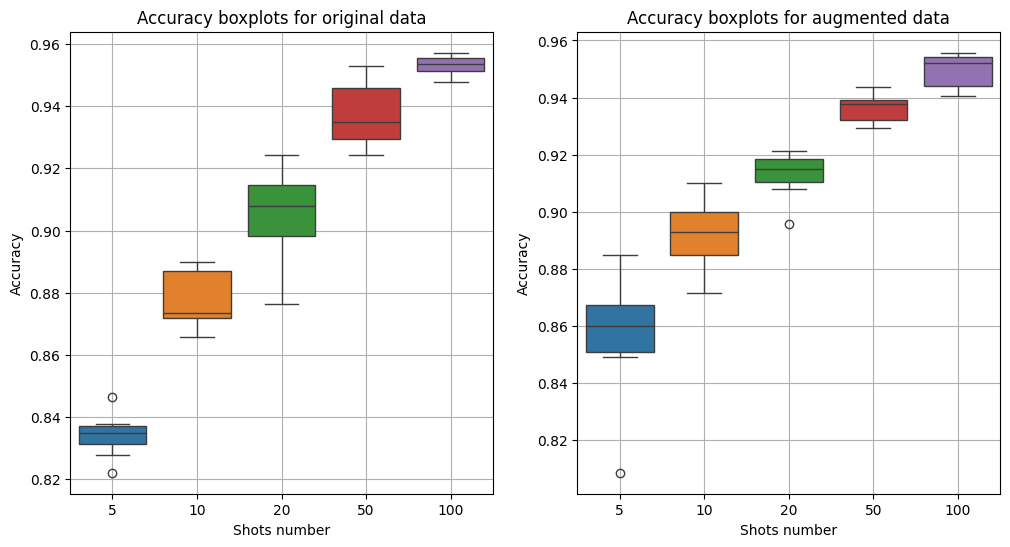

In [85]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.boxplot(accs, ax=axes[0])
sns.boxplot(aug_accs, ax=axes[1])

axes[0].set_title('Accuracy boxplots for original data')
axes[1].set_title('Accuracy boxplots for augmented data')

for ax in range(2):
    axes[ax].set_xlabel("Shots number")
    axes[ax].set_ylabel("Accuracy")
    axes[ax].grid(True)

plt.show()

In [87]:
prcs = {}
aug_prcs = {}

for shot_val in shots_values:
    prcs[shot_val] = stats[shot_val]['Precision']
    aug_prcs[shot_val] = aug_stats[shot_val]['Precision']

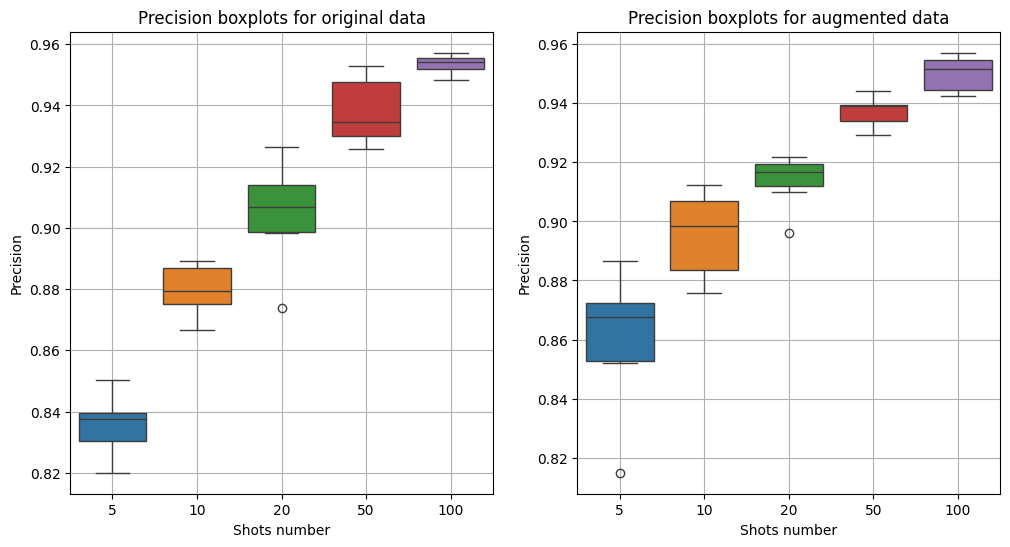

In [88]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.boxplot(prcs, ax=axes[0])
sns.boxplot(aug_prcs, ax=axes[1])

axes[0].set_title('Precision boxplots for original data')
axes[1].set_title('Precision boxplots for augmented data')

for ax in range(2):
    axes[ax].set_xlabel("Shots number")
    axes[ax].set_ylabel("Precision")
    axes[ax].grid(True)

plt.show()

In [89]:
rcls = {}
aug_rcls = {}

for shot_val in shots_values:
    rcls[shot_val] = stats[shot_val]['Recall']
    aug_rcls[shot_val] = aug_stats[shot_val]['Recall']

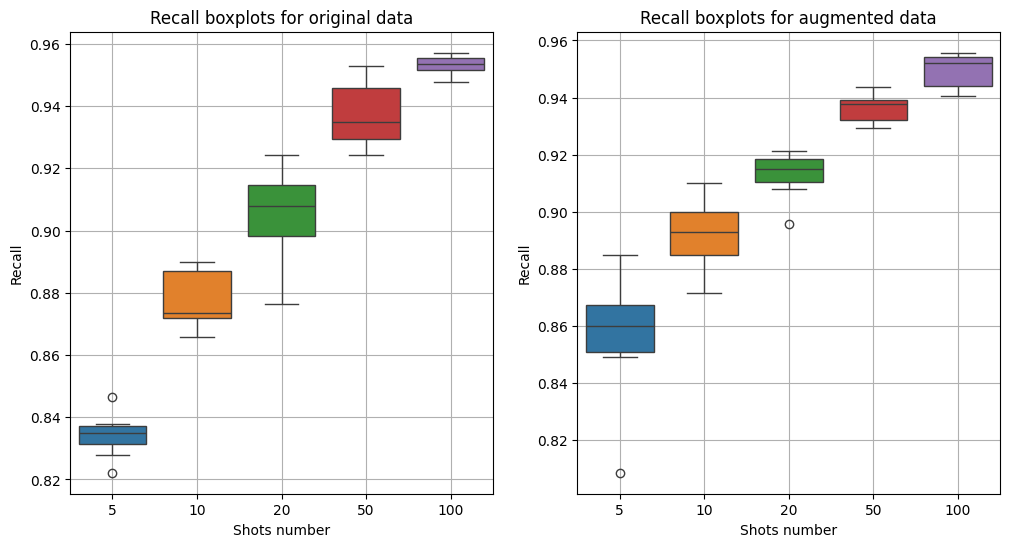

In [90]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.boxplot(rcls, ax=axes[0])
sns.boxplot(aug_rcls, ax=axes[1])

axes[0].set_title('Recall boxplots for original data')
axes[1].set_title('Recall boxplots for augmented data')

for ax in range(2):
    axes[ax].set_xlabel("Shots number")
    axes[ax].set_ylabel("Recall")
    axes[ax].grid(True)

plt.show()

In [91]:
f1s = {}
aug_f1s = {}

for shot_val in shots_values:
    f1s[shot_val] = stats[shot_val]['F1']
    aug_f1s[shot_val] = aug_stats[shot_val]['F1']

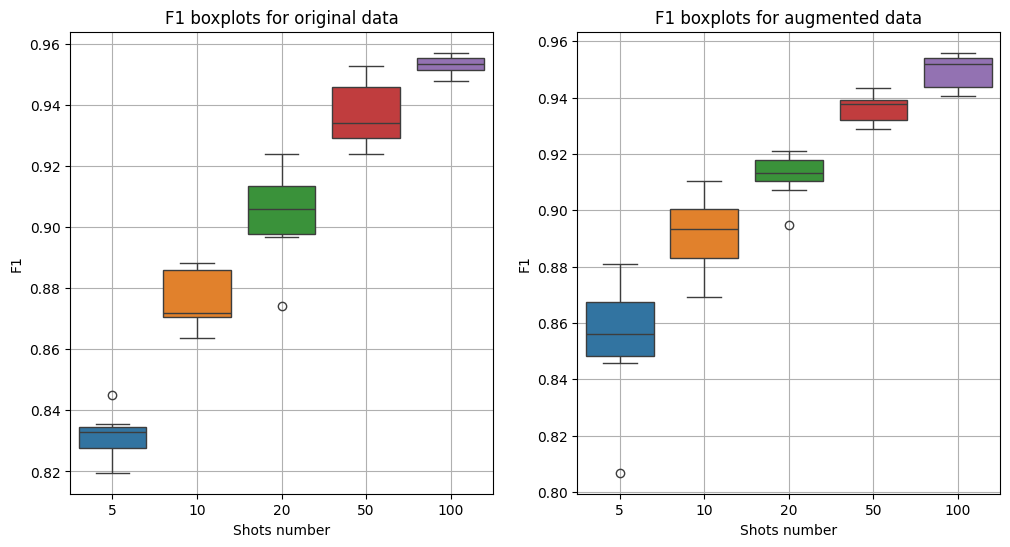

In [92]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.boxplot(f1s, ax=axes[0])
sns.boxplot(aug_f1s, ax=axes[1])

axes[0].set_title('F1 boxplots for original data')
axes[1].set_title('F1 boxplots for augmented data')

for ax in range(2):
    axes[ax].set_xlabel("Shots number")
    axes[ax].set_ylabel("F1")
    axes[ax].grid(True)

plt.show()